In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [2]:
from basic_functions_gaussian import compute_depth, compute_depth_analytical, flatten, my_group_fun

### limit values

In [37]:
alpha = 0.5

sigma = 0.1
gexp = 0.3
sigma_exps = [0.02, 0.04, 0.06, 0.08, 0.1, 0.12, 0.14]

n = np.int64(1e4)

cycle over different values of $\sigma_{exp}$

In [38]:
out1 = {}
out2 = {}

for sigma_exp in sigma_exps:
    
    print(sigma_exp)

    out1[sigma_exp] = {}
    
    for m in range(5):
        out1[sigma_exp][m] = compute_depth(n, sigma, gexp, sigma_exp, alpha, delta_lambda=100)
    
    out2[sigma_exp] = compute_depth_analytical(n, sigma, gexp, sigma_exp, alpha)


0.02
0.04
0.06
0.08
0.1
0.12
0.14


In [39]:
print(vars(out2[sigma_exp]).keys())

out2[sigma_exp].lim_value

dict_keys(['lambda_min', 'avg_min', 'loss_min', 'gbar', 'lim_chi2', 'lim_dkl', 'lim_value', 'dV'])


4.737054039650612

In [40]:
print(vars(out1[sigma_exp][m]).keys())
print(vars(out2[sigma_exp]).keys())

dict_keys(['g', 'mini', 'min_lambda', 'min_loss', 'min_avg', 'gbar', 'lim_loss', 'lim_loss_num', 'lim_chi2', 'lim_dkl', 'dV'])
dict_keys(['lambda_min', 'avg_min', 'loss_min', 'gbar', 'lim_chi2', 'lim_dkl', 'lim_value', 'dV'])


In [8]:
def compute_mean_std(out, s, j = None):
    
    mean = []
    std_mean = []
    
    for n in out.keys():
        mean.append(np.mean(flatten(out[n], s, j)))
        std_mean.append(np.std(flatten(out[n], s, j))/np.sqrt(len(out[n].keys())))
    
    return mean, std_mean

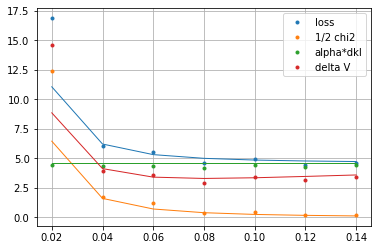

In [41]:
j = 0  # 0 or 1, depending on max/min g

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']  # ,'tab:purple','tab:brown','tab:pink',
          #   'tab:gray','tab:olive','tab:cyan']

mean_loss, std_loss = compute_mean_std(out1, 'lim_loss_num', j)
plt.plot(sigma_exps, mean_loss, '.', label='loss', c=colors[0])
plt.plot(sigma_exps, flatten(out2, 'lim_value'), c=colors[0])

mean, std = compute_mean_std(out1, 'lim_chi2', j)
plt.plot(sigma_exps, 1/2*np.array(mean), '.', label='1/2 chi2', c=colors[1])
plt.plot(sigma_exps, 1/2*np.array(flatten(out2, 'lim_chi2')), c=colors[1])

# overestimate of the chi2 with sqrt(log(n))
# plt.plot(sigma_exps, 1/2*((sigma*np.sqrt(2*np.log(sigma_exps)) - gexp)/sigma_exp)**2, label='1/2 chi2 est')

mean, std = compute_mean_std(out1, 'lim_dkl', j)
plt.plot(sigma_exps, alpha*np.array(mean), '.', label='alpha*dkl', c=colors[2])
plt.plot(sigma_exps, alpha*np.array(flatten(out2, 'lim_dkl')), c=colors[2])

mean, std = compute_mean_std(out1, 'dV')
plt.plot(sigma_exps, mean, '.', label='delta V', c=colors[3])
plt.plot(sigma_exps, flatten(out2, 'dV'), c=colors[3])

plt.grid()
# plt.xscale('log')
# plt.yscale('log')
plt.legend()

### Metropolis sampling

In [42]:
from basic_functions_bayesian import compute_single, compute, run_Metropolis
from basic_functions_gaussian import loss_fun

In [43]:
p0 = np.ones(n)/n
g = np.random.normal(0, sigma, size=n)

In [44]:
def energy_function(x, p0, g, gexp, sigma_exp, alpha, if_jeffreys = False):

    out = loss_fun(x, p0, g, gexp, sigma_exp, alpha, if_cov=if_jeffreys)

    if if_jeffreys:
        energy = out[0]
        cov = out[-1]
        jeff = np.log(np.linalg.det(cov))
        energy -= jeff

    else:
        energy = out

    return np.array([energy])

Text(0.5, 0, 'n frames')

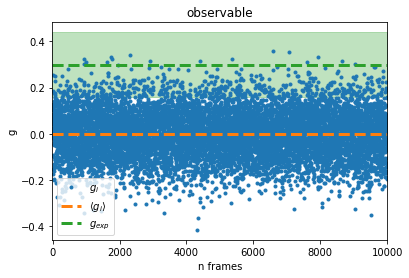

In [45]:
plt.rcParams['lines.linewidth'] = 3

plt.plot(g, '.', label=r'$g_i$')

plt.plot([-5, len(g) + 5], [np.mean(g), np.mean(g)], '--', label=r'$\langle g_i\rangle$')  # ,color='tab:blue')

plt.plot([-5, len(g) + 5], [gexp, gexp], '--', label=r'$g_{exp}$')
plt.fill_between([-5, len(g) + 5], [gexp - sigma_exp, gexp - sigma_exp], [gexp + sigma_exp, gexp + sigma_exp], alpha=0.3, color='tab:green')

plt.title('observable')
plt.legend(loc='lower left')
plt.xlim([-5, len(g) + 5])
plt.ylabel('g')
plt.xlabel('n frames')

In [46]:
dV = compute_depth_analytical(n, sigma, gexp, sigma_exp, alpha).dV

print(dV)

3.6006904032869764


In [47]:
out = compute_depth(n, np.array([g]), gexp, sigma_exp, alpha, if_scan=True, delta_lambda=100)

In [48]:
vars(out).keys()

dict_keys(['g', 'mini', 'min_lambda', 'min_loss', 'min_avg', 'gbar', 'lim_loss', 'lim_loss_num', 'lim_chi2', 'lim_dkl', 'dV', 'scan_lambdas', 'scan_results', 'scan_loss_min', 'scan_lambda_min', 'scan_avg_min'])

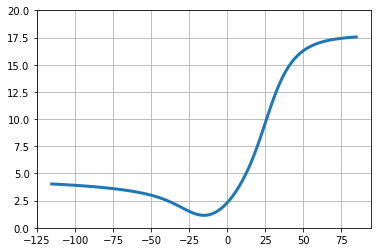

In [49]:
plt.plot(out.scan_lambdas, out.scan_results['lossf'])
plt.ylim([0, 20])
plt.grid()

Text(0.5, 1.0, 'derivative')

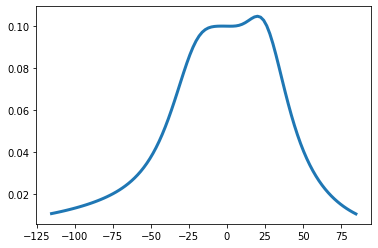

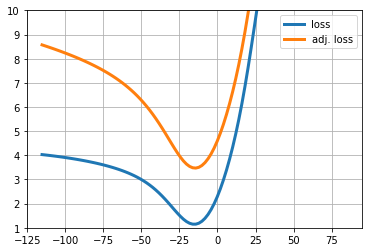

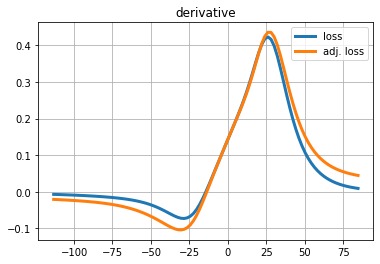

In [50]:
out_compute = compute(out.scan_lambdas, p0, g, gexp, sigma_exp, alpha)

plt.plot(out.scan_lambdas, out_compute['std_g'])

plt.figure()
plt.plot(out.scan_lambdas, out.scan_results['lossf'], label='loss')

adj_loss = out.scan_results['lossf'] - np.log(out_compute['jeffreys'])
plt.plot(out.scan_lambdas, adj_loss, label='adj. loss')
plt.grid()
plt.legend()
# plt.yscale('log')
plt.ylim([1, 10])

plt.figure()

def num_der(x, y):
    dy_dx = np.ediff1d(y)/np.ediff1d(x)
    return dy_dx

plt.plot(out.scan_lambdas[1:], num_der(out.scan_lambdas, out.scan_results['lossf']), label='loss')
plt.plot(out.scan_lambdas[1:], num_der(out.scan_lambdas, adj_loss), label='adj. loss')
plt.grid()
plt.legend()
plt.title('derivative')

In [51]:
my_energy_function = lambda x : energy_function(x, p0, g, gexp, sigma_exp, alpha, False)

out_Metropolis = run_Metropolis(np.zeros(1), 5., my_energy_function, n_steps=10000)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900


In [52]:
my_energy_function = lambda x : energy_function(x, p0, g, gexp, sigma_exp, alpha, True)

out_J_Metropolis = run_Metropolis(np.zeros(1), 5., my_energy_function, n_steps=10000)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900


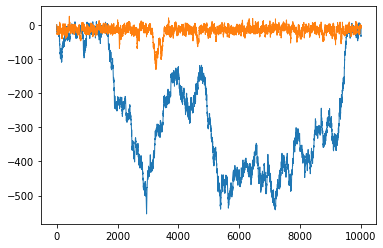

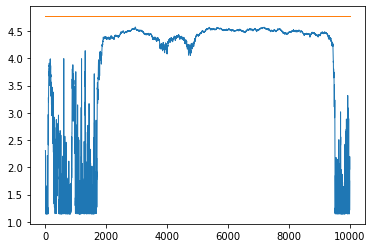

In [53]:
plt.rcParams['lines.linewidth'] = 1

plt.plot(out_Metropolis[0])
plt.plot(out_J_Metropolis[0])

plt.figure()
plt.plot(out_Metropolis[1])
# plt.plot(out_J_Metropolis[1])

# val = out2[sigma_exp].lim_value
val = compute_depth(n, sigma, gexp, sigma_exp, alpha, delta_lambda=100).lim_loss[0]
plt.plot([0, len(out_Metropolis[1])], [val, val])

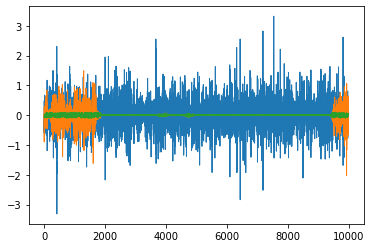

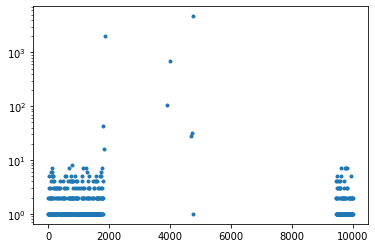

In [69]:
dif = np.ediff1d(out_Metropolis[1])
dif_J = np.ediff1d(out_J_Metropolis[1])

wh = np.where(dif != 0)
wh2 = np.where(np.abs(dif) < 0.1)
wh = np.intersect1d(wh, wh2)

plt.plot(dif_J)
plt.plot(dif)
plt.plot(wh, dif[wh])
# plt.xlim([0, 2000])

gr = my_group_fun(dif, 0, 0.05)

plt.figure()
plt.plot(gr[0], gr[1], '.')
plt.yscale('log')


In [78]:
gr[0][np.where(np.array(gr[1]) > 100)[0][0]]

1855

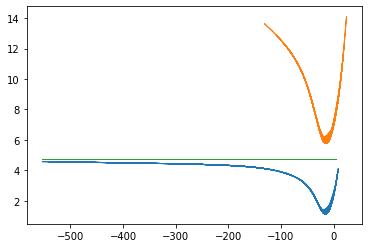

In [54]:
plt.plot(out_Metropolis[0], out_Metropolis[1])
plt.plot(out_J_Metropolis[0], out_J_Metropolis[1])
plt.plot([np.min(out_Metropolis[0]), np.max(out_Metropolis[1])], val*np.ones(2))


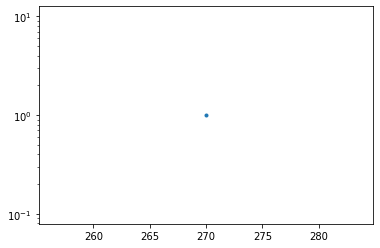

In [23]:
out = my_group_fun(out_Metropolis[1], val, 0.2)

plt.plot(out[0], out[1], '.')
plt.yscale('log')

### Metropolis sampling - cycle over $\sigma_{exp}$

In [ ]:
out1[sigma_exp][m] = compute_depth(n, sigma, gexp, sigma_exp, alpha, delta_lambda=100)

In [80]:
sigma_exps

[0.02, 0.04, 0.06, 0.08, 0.1, 0.12, 0.14]

In [95]:
n_steps = 5000

dV = {}
out = {}
# ind = {}
out_Metropolis = {}
out_J_Metropolis = {}

for sigma_exp in sigma_exps:

    print(sigma_exp)

    dV[sigma_exp] = compute_depth_analytical(n, sigma, gexp, sigma_exp, alpha).dV

    out[sigma_exp] = compute_depth(n, np.array([g]), gexp, sigma_exp, alpha, if_scan=True, delta_lambda=100)
    out_compute = compute(out[sigma_exp].scan_lambdas, p0, g, gexp, sigma_exp, alpha)

    my_energy_function = lambda x : energy_function(x, p0, g, gexp, sigma_exp, alpha, False)

    out_Metropolis[sigma_exp] = run_Metropolis(np.zeros(1), 5., my_energy_function, n_steps=n_steps)

    my_energy_function = lambda x : energy_function(x, p0, g, gexp, sigma_exp, alpha, True)

    out_J_Metropolis[sigma_exp] = run_Metropolis(np.zeros(1), 5., my_energy_function, n_steps=n_steps)

    # dif = np.ediff1d(out_Metropolis[sigma_exp][1])
    # group = my_group_fun(dif, 0, 0.05)
    # ind[sigma_exp] = group[0][np.where(np.array(group[1]) > 100)[0][0]]

    clear_output()

In [102]:
out_Metropolis[0.04]

(array([[  0.        ],
        [  0.        ],
        [ -0.59643111],
        ...,
        [-34.95668034],
        [-31.3548428 ],
        [-31.10781612]]),
 array([28.267906 , 28.267906 , 27.163565 , ...,  2.257364 ,  2.1869173,
         2.1895478], dtype=float32),
 0.8748)

In [96]:
ind = {}

for sigma_exp in out_Metropolis.keys():
    dif = np.ediff1d(out_Metropolis[sigma_exp][1])
    group = my_group_fun(dif, 0, 0.05)
    wh = np.where(np.array(group[1]) > 100)[0]
    if not (len(wh) == 0):
        ind[sigma_exp] = group[0][wh[0]]
    else:
        ind[sigma_exp] = None



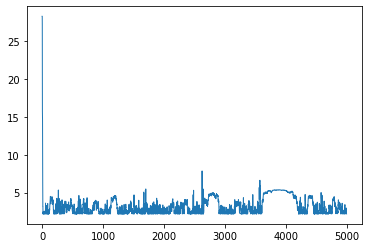

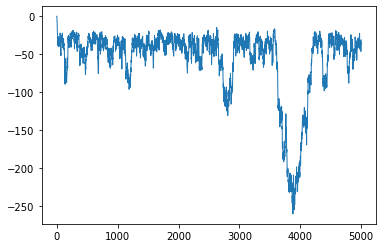

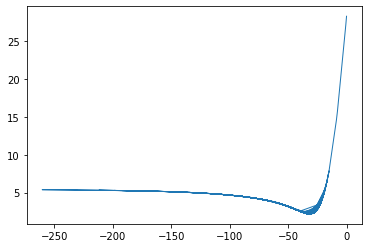

In [101]:
plt.plot(out_Metropolis[0.04][1])

plt.figure()
plt.plot(out_Metropolis[0.04][0])

plt.figure()
plt.plot(out_Metropolis[0.04][0], out_Metropolis[0.04][1])

In [97]:
ind

{0.02: None,
 0.04: 3761,
 0.06: 1844,
 0.08: 3020,
 0.1: None,
 0.12: None,
 0.14: 2025}

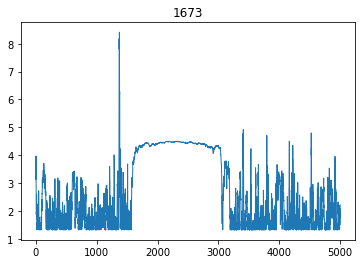

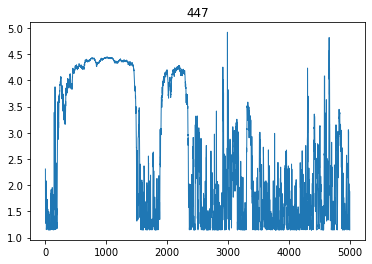

In [85]:
for sigma_exp in sigma_exps[-2:]:
    plt.figure()
    plt.plot(out_Metropolis[sigma_exp][1])
    # plt.title(out[sigma_exp].lim_loss)
    plt.title(ind[sigma_exp])

7.978613733244856


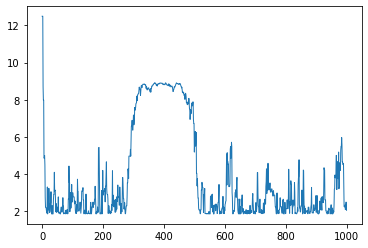

In [97]:
sigma_exp = sigma_exps[-5]

val = out2[sigma_exp].lim_value
print(val)

plt.plot(out_Metropolis[sigma_exp][1])

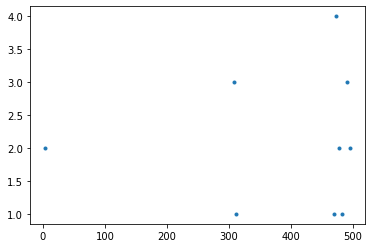

In [99]:
out = my_group_fun(out_Metropolis[sigma_exp][1], val, 0.2)

plt.plot(out[0], out[1], '.')
# plt.yscale('log')